![Logo](assets/logo.png)

Created by: **Domonkos Nagy**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/6.%20n-step%20TD/taxi.ipynb)

# Taxi

The Taxi Problem involves navigating to passengers in a grid world, picking them up and dropping them off at one of four locations.

![Example image](assets/taxi.png)

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.
The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

There are 6 possible actions: movement in any of the 4 directions (up, down, right, left) alongside with picking up and dropping off the passenger. The problem has 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

The rewards of this problem consist of:

- -1 per step unless other reward is triggered,

- +20 for delivering passenger,

- -10 for executing “pickup” and “drop-off” actions illegally.

As usual we are using `gymnasium` to model the environment. To solve this problem, we are going to utilize an $n$*-step bootstrapping* technique, namely the $n$*-step tree backup algorithm*.

- Documentation for the Taxi environment: https://gymnasium.farama.org/environments/toy_text/taxi/

In [1]:
import gymnasium as gym
import numpy as np
import pickle
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from IPython import display
import time
import math

In [2]:
env = gym.make('Taxi-v3', render_mode='rgb_array')  # creating the environment

In [3]:
# initializing q-table
action_space_size = env.action_space.n
observation_space_size = env.observation_space.n

q_table = np.zeros((observation_space_size, action_space_size))

In [4]:
# hyperparameters
N_EPISODES = 10_000
MAX_STEPS_PER_EPISODE = 200

N_STEPS = 2  # number of steps to sample from
ALPHA = 0.4  # learning rate
GAMMA = 1  # discount rate

EPSILON = 1  # exploration rate
EPSILON_MIN = 0.1
EPSILON_DECAY = (2 * EPSILON) / N_EPISODES

LOG_RATE = N_EPISODES / 10

In [5]:
# helper functions for the training algorithm

# epsilon-greedy action selection
def select_action(epsilon, state):
    if np.random.rand() > epsilon:
        return np.argmax(q_table[state, :])
    else:
        return env.action_space.sample()

# convert action-values to state-values
def state_value(state):
    return np.max(q_table[state, :])

## $n$-step bootstrapping

$n$-step bootstrapping can be seen as a generalization of MC and TD methods. Both of these methods have the same update rule:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha\left[G - Q(S_t, A_t)\right]$$

The difference is in $G$, often called the *target* of the update. The target of a MC update at time $t$ is the discounted return
from the state $S_t$ up to the terminal state: $G_t^{(MC)} := R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-t-1} R_{T}$. In the case
of TD learning, the target is $G_t^{(TD)} := R_{t+1} + V(S_{t+1})$. While the MC target consists of only sample rewards from the currently simulated
episode, the TD target only takes 1 sample reward into account, and then it *bootstraps*, by using the estimate of the next state to update the estimate
of the current one.

$n$-step bootstrapping basically combines these two ideas together: the target for this update is made up by $n$ sample rewards, and then the estimate of the
resulting state:

$$G_{t:t+n} := R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^n V(S_{t+n})$$

### The $n$-step Tree Backup Algorithm

An off-policy version of $n$-step bootstrapping that does not utilize importance sampling is called the $n$*-step tree backup algorithm*. This algorithm utilizes
a mix of expected updates and sample updates: for all non-selected actions, the estimated values are taken into account (just like an expected update), but for
the selected action, the actual next target is added:

$$G_{t:t+n} := R_{t+1} + \gamma \sum_{a\ne A_t} \pi(a|S_{t+1})Q(S_{t+1},a) + \gamma \pi(A_{t+1} | S_{t+1}) G_{t+1:t+n} \; (\text{where} \; G_{T-1:t+n} := R_T)$$

In our case, the target policy $\pi$ is greedy, so $\pi(a|s)\in\{0,1\}\ \ \forall{a\in \mathcal{A}, s\in \mathcal{S}}$. This means that the above formula can be simplified:

$$
  G_{t:t+n} :=
    \begin{cases}
      R_{t+1} + \gamma G_{t+1:t+n} & \text{if $\pi(S_{t+1}) = A_{t+1}$}\\
      R_{t+1} + \gamma Q(S_{t+1},\pi(S_{t+1})) & \text{if $\pi(S_{t+1}) \ne A_{t+1}$}
    \end{cases},
$$

where $\pi(s)$ is the action $a$ for which $\pi(a|s) = 1$ in state $s$.

In [6]:
# training function
def train(q_table, alpha=ALPHA, n_steps=N_STEPS,
          n_episodes=N_EPISODES, epsilon=EPSILON,
          epsilon_decay=EPSILON_DECAY, log=True):
    sum_rewards = 0
    episodes = trange(n_episodes) if log else range(n_episodes)

    # training
    for episode in episodes:
        state, _ = env.reset()
        truncated = False

        # selecting first action
        action = select_action(epsilon, state)

        # storing the trajectory
        states = [state]
        actions = [action]
        rewards = [0]

        tau = -n_steps + 1  # the time step for which we update the q_table
        time_step = 0
        terminal_step = np.inf

        while tau < terminal_step:
            # if the episode is still running, take next action
            if time_step < terminal_step:
                new_state, reward, done, _, info = env.step(action)

                # saving trajectory
                states.append(new_state)
                rewards.append(reward)

                sum_rewards += reward
                truncated = (not done) and (time_step >= MAX_STEPS_PER_EPISODE)

                if done or truncated:
                    terminal_step = time_step + 1
                else:
                    action = select_action(epsilon, new_state)
                    actions.append(action)
                    state = new_state

            # update q_table for the action taken n steps ago
            if tau >= 0:
                target = 0

                # setting the last term of the target
                if time_step + 1 >= terminal_step:
                    target = rewards[terminal_step] + \
                        GAMMA * state_value(states[terminal_step])
                else:
                    target = rewards[time_step + 1] + \
                        GAMMA * state_value(states[time_step + 1])

                # looping back in the trajectory, updating target
                for k in range(min(terminal_step - 1, time_step), tau, -1):
                    if actions[k] == np.argmax(q_table[states[k], :]):
                        target = rewards[k] + GAMMA * target
                    else:
                        target = rewards[k] + GAMMA * state_value(states[k])

                # updating q_table
                q_table[states[tau], actions[tau]] += alpha * \
                    (target - q_table[states[tau], actions[tau]])

            time_step += 1
            tau += 1

        # updating epsilon
        epsilon = max(epsilon - epsilon_decay, EPSILON_MIN)

        # logging the results
        if log and (episode + 1) % LOG_RATE == 0:
            print(f'Episode {episode + 1} : avg={sum_rewards / LOG_RATE}')
            sum_rewards = 0

    return q_table

In [7]:
# training
q_table = train(q_table)

# saving the q-table
with open('q_table.bin', 'wb') as f:
    pickle.dump(q_table, f)

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 1000 : avg=-543.555
Episode 2000 : avg=-152.518
Episode 3000 : avg=-49.755
Episode 4000 : avg=-14.708
Episode 5000 : avg=0.858
Episode 6000 : avg=2.558
Episode 7000 : avg=2.541
Episode 8000 : avg=2.259
Episode 9000 : avg=2.421
Episode 10000 : avg=2.634


**Playing the game**: Here we simulate 3 episodes using the resulting policy:

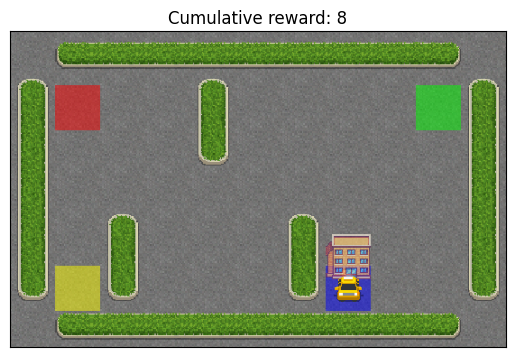

In [8]:
env = gym.make('Taxi-v3', render_mode='rgb_array')

# loading the q-table
with open('q_table.bin', 'rb') as f:
    q_table = pickle.load(f)

plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

env.reset()
img = plt.imshow(env.render())

for episode in range(3):
    state, _ = env.reset()
    done = False
    sum_reward = 0

    plt.title(f"Episode #{episode + 1}")
    for step in range(MAX_STEPS_PER_EPISODE):
        action = np.argmax(q_table[state, :])  # greedy action selection

        new_state, reward, done, truncated, info = env.step(action)
        sum_reward += reward

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(f'Cumulative reward: {sum_reward}')

        if done:
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(1)
            break

        state = new_state

env.close()

## Finding the optimal $n$

Unsurprisingly, there is no generally best value for $n$, it depends on the problem. The method will eventually converge to the optimal policy and value function
regardless of the choice of $n$, the difference is in the speed of convergence. The plot below compares different values of $n$ and $\alpha$ at different levels
of training.

In [9]:
def test(q_table, n_episodes=N_EPISODES):
    sum_reward = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False

        for step in range(MAX_STEPS_PER_EPISODE):
            action = np.argmax(q_table[state, :])

            new_state, reward, done, truncated, info = env.step(action)
            sum_reward += reward

            state = new_state

            if done:
                break

    return sum_reward / n_episodes

In [10]:
# hyperparameters to compare
episode_counts = [100, 500, 1000, 5000]
step_counts = [1, 2, 4]
alphas = np.linspace(0.1, 1, 10)
n_trials = 20

# comparing parameters
comparison_results = np.zeros((len(episode_counts), len(step_counts), len(alphas)))
for t in range(n_trials):
    display.clear_output(wait=True)
    print(f'Trial {t+1}/{n_trials}')

    # evaluating for all episode counts
    for i, n_episodes in enumerate(tqdm(episode_counts)):
        # evaluating for all values of n
        for j, n_steps in enumerate(tqdm(step_counts)):
            # evaluating for all values of alpha
            for k, alpha in enumerate(alphas):
                q_table = np.zeros((observation_space_size, action_space_size))
                epsilon = 1
                epsilon_decay = (2 * epsilon) / n_episodes

                q_table = train(q_table, alpha=alpha, n_steps=n_steps,
                                n_episodes=n_episodes, epsilon=epsilon,
                                epsilon_decay=epsilon_decay, log=False)

                comparison_results[i, j, k] += test(q_table, 100)

# averaging performance over n_trials
comparison_results = comparison_results / n_trials

with open('comparison_results.bin', 'wb') as f:
    pickle.dump(comparison_results, f)

Trial 20/20


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

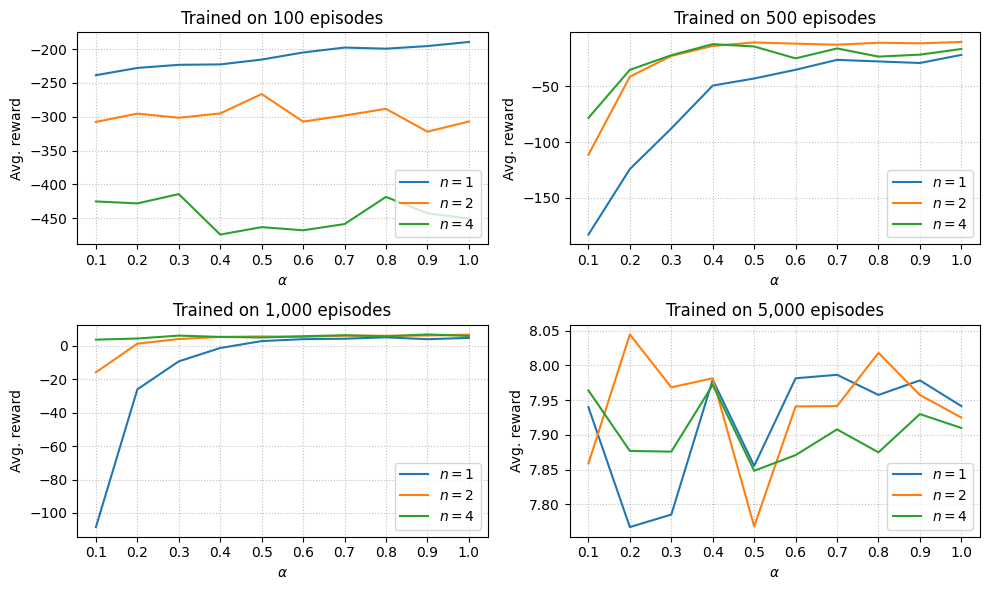

In [12]:
with open('comparison_results.bin', 'rb') as f:
    comparison_results = pickle.load(f)

# setting up the plot
nrows = math.ceil(len(step_counts) / 2)
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 3*nrows))
axs = axs.flatten()

# plotting results
for i, n_episodes in enumerate(episode_counts):
    ax = axs[i]
    ax.set_title(f'Trained on {n_episodes:,} episodes')

    for j, n_steps in enumerate(step_counts):
        ax.plot(alphas, comparison_results[i, j, :], label=f'$n={n_steps}$',
                zorder=2)

    ax.legend(loc='lower right')
    ax.set_ylabel('Avg. reward')
    ax.set_xlabel('$\\alpha$')
    ax.set_xticks(alphas)
    ax.grid(alpha=0.8, linestyle=':', zorder=0)

plt.tight_layout()
plt.show()